# Simulación de seguro de desempleo y CTS



## Datos y paquetes útiles para el análisis

Importamos paquetes útiles para el análisis y subimos una base de datos construida a partir de las respuestas del experimento de preferencias de Jaramillo et al.

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from tabulate import tabulate
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Preferencias Grade')

prefs = pd.read_csv('data_aplicacion.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unos datos descriptivos de algunas de las variables más importantes con las que contamos:

In [ ]:
prefs['pdesp'] = prefs['pdesp']
d = prefs[['rhat', 'dhat', 'pdesp', 'w']].describe()
print(tabulate(round(d, 4), headers = d.keys()))

            rhat       dhat     pdesp         w
-----  ---------  ---------  --------  --------
count  1298       1298       813        1298
mean      0.953      1.2565    1.9975   1548.47
std       1.3763     0.5618    1.7811   1078.52
min      -3.7652    -0.6507    1         120
25%       0.5802     1.0936    1         900
50%       1.0679     1.5318    1        1200
75%       1.5266     1.5898    2        1800
max       6.0976     2.445    10       14400


* Las variables 'rhat' y 'dhat' toman los valores de los parámetros de funciones de preferencias de riesgo y tiempo, respectivamente, de cada sujeto. Estos parámetros vienen del modelo de preferencias conjunto con efectos aleatorios de Luce que estimamos en Jaramillo et al. y usaremos para evaluar el bienestar que genera el seguro de desempleo y el CTS. Los promedios muestran que tratamos con una población bastante aversa al riesgo e impaciente (aunque heterogénea).

* La variable 'pdesp' toma valores del .1 a 1, representando la probabilidad *subjetiva* de cada sujeto sobre la perdida de su empleo en los siguientes 6 meses.

* La variable 'w' representa el ingreso total mensual de cada sujeto.



## La probabilidad subjetiva y objetiva de despido

### Limpiar e imputar nuevos datos 

Ya que 30% de los encuestados no contaban con trabajo, modelamos su probabilidad subjetiva de despido como extracciones de la distribución de respuestas de los que si contaban con empleo.

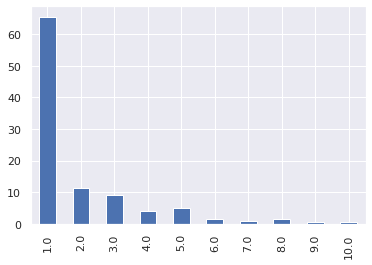

In [ ]:
from random import randint, choice, uniform, seed

seed(10)

# escoger entre la distribución de prob desp existente para los nans
sequence = prefs[prefs['pdesp'].notnull()]['pdesp'].values  

prefs['pdesp'] = prefs.apply(lambda d: choice(sequence) if np.isnan(d['pdesp']) else d['pdesp'], axis = 1)
prefs['pdesp'].value_counts(normalize = True).mul(100).sort_index().plot.bar();

Como se puede apreciar en el gráfico, la gran mayoría (65%) cree que su probabilidad de despido es 1/10 (la opción más baja). Menos del 5% de encuestados creen que la su probabilidad de despido es mayor a 5/10.

### Transformar probabilidad de despido a base mensual

Para la simulación, debemos transformar la probabilidad de despido a una base mensual. Para esto, la tratamos como una variable aleatoria geométrica, y simplemente la dividimos entre 6. De esta manera, interpretamos que una persona que cree que con probabilidad 10/10 perderá su trabajo en los siguientes 6 meses **espera**
perder su trabajo en 6 meses o menos. Entonces, si X es meses empleado, tenemos que: 

X ~ geom(p ≥ 1/6) 

Para volver el modelo algo más realista proponemos que la probabilidad real de despido no sea exactamente igual a la subjetiva. Modelamos la probabilidad real de despido como una extracción de una distribución uniforme entre la opción menor y mayor, realizada mes a mes. (Hacemos esto para todos los casos menos el de 10/10, donde p se extrae de una dist. uniforme entre 9/10 y 1).  

Usando métodos de Monte Carlo, vemos que este modelo genera las probabilidades despido mensuales (condicional en estar empleado) expuestas en la siguiente tabla:


In [ ]:
prefs['prd'] = prefs['pdesp']/60 # Transformar probabilidad despido a base mensual

def pdesp_mes(prd):
  '''
  prd: probabilidad de despido subjetiva 
  returns: probabilidad de despido objetiva
  '''
  return uniform((prd-1/60), 1) if (prd == 1/6 or prd == 1/6**(1/2)) else uniform((prd-1/60), (prd+1/60))

pds = list(map(lambda x: x/60, range(1, 11))) 
d = dict(zip(pds, 10*[0]))
rounds, total_rounds = 0, 50000

while rounds < total_rounds:
  rounds += 1 
  for prd in pds:
    d[prd] += pdesp_mes(prd)

freqs = {k: v/total_rounds for k, v in d.items()}
print(tabulate(freqs.items(), headers = ['prob. despido encuesta', 'prob. despido / mes | empleado']))

  prob. despido encuesta    prob. despido / mes | empleado
------------------------  --------------------------------
               0.0166667                         0.0166555
               0.0333333                         0.0333125
               0.05                              0.0500041
               0.0666667                         0.06665
               0.0833333                         0.0833491
               0.1                               0.0999502
               0.116667                          0.116624
               0.133333                          0.13334
               0.15                              0.149994
               0.166667                          0.576186


### La probabilidad de despido y reinserción es dependendiente del estado de empleo actual

De manera similar, proponemos que la probabilidad de tener empleo sea condicional al estado actual (empleado vs. desempleado). Si una persona tiene empleo la probabilidad de mantenerlo es el complemento de lo descrito anteriormente. 

Por otro lado, pensamos que un supuesto más realista para la población desempleada es que la probabilidad con la que se reinsertan al mercado laboral sea menor a la probabilidad con la que mantienen su trabajo. De esta manera, modelamos la probabilidad de recuperar el empleo como el complemento de la probabilidad de despido subjetiva divida entre dos.

In [ ]:
def estado_empleo(empleado, prd):
  '''
  empleado: estado de empleo en el periodo t (1, 0)
  prd: probabilidad subjetiva de despido
  returns: estado de empleo en el periodo t + 1
  '''
  if empleado:
    return 1 if pdesp_mes(prd) < uniform(0, 1) else 0
  else: 
    return 1 if pdesp_mes(prd)**(1/2) < uniform(0, 1) else 0 #TO DO: 2*pdesp_mes(pd) ?????

En el siguiente cuadro visualizamos la probabilidad de no tener trabajo en el siguiente periodo condicional a estar empleado o no estar empleado.

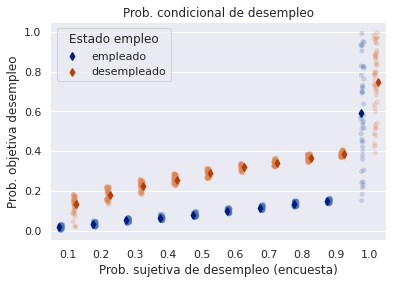

In [ ]:
from collections import defaultdict

resultados = {'empleado': defaultdict(list), 'desempleado': defaultdict(list)}

for prd in pds:
  for i in range(45):
    resultados['empleado'][prd].append(pdesp_mes(prd))
    resultados['desempleado'][prd].append(pdesp_mes(prd)**(1/2))

res = pd.concat({
      k: pd.DataFrame.from_dict(v, 'index') for k, v in resultados.items()
    }, 
    axis=0).stack().reset_index()

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

g = sns.stripplot(x='level_1', y=0, hue="level_0", jitter = .1,
              data=res, dodge=True, alpha=.25, zorder=1)

sns.pointplot(x='level_1', y=0, hue="level_0", jitter = .1,
              data=res, dodge=.5, join=False, palette="dark",
              markers="d", scale=.75, ci=True)
# Mejorar leyenda
handles, labels = g.get_legend_handles_labels()
plt.legend(handles[2:], labels[2:], title="Estado empleo", loc="upper left")
plt.xlabel('Prob. sujetiva de desempleo (encuesta)')
plt.ylabel('Prob. objetiva desempleo')
plt.title(r'Prob. condicional de desempleo')
g.set_xticklabels(list(map(lambda x: x/10, range(1,11))));

### Probabilidad condicional de empleo 

Calculamos la probabilidad de estar empleado para cada probalidad subjetiva de despido y para los empleados y desempleados. Los resultados del ejericio expuestos en la tabla muestran que generamos una distribución de probabilidades de empleo plausible.  

In [ ]:
total_rounds = 50000
prob_empleo_si_empleado = []
prob_empleo_si_desempleado = []
for prd in pds:
  prob_empleo_si_empleado.append(sum([estado_empleo(1, prd) for i in range(total_rounds)])/total_rounds)
  prob_empleo_si_desempleado.append(sum([estado_empleo(0, prd) for i in range(total_rounds)])/total_rounds)

table = zip(pds, prob_empleo_si_empleado, prob_empleo_si_desempleado)
print(tabulate(table, headers = ['prob.', 'prob. mantener empleo', 'prob. recuperar empleo']))

    prob.    prob. mantener empleo    prob. recuperar empleo
---------  -----------------------  ------------------------
0.0166667                  0.98294                   0.87878
0.0333333                  0.96652                   0.81838
0.05                       0.95088                   0.77452
0.0666667                  0.93496                   0.74114
0.0833333                  0.9182                    0.71532
0.1                        0.89916                   0.68408
0.116667                   0.87888                   0.6604
0.133333                   0.86662                   0.63532
0.15                       0.84834                   0.61162
0.166667                   0.42556                   0.26078


### Probabilidad total de empleo
Para simular el seguro de desempleo debemos saber la distribución de la variable de empleo que hemos creado. Ya que modelamos el estado de empleo como es una combinación de varias distribuciones y de manera condicionalmente dependiente al estado del periodo anterior, usamos métdos de Monte Carlo para describir sus propiedades numericamente.

Por cada posible probabilidad de desempleo subjetiva simulamos proceso de empleo de un sujeto N veces.

In [ ]:
estado = dict(zip(pds, 10*[1])) # empiezan todos empleados
resultados = defaultdict(list)

for prd in pds:
  rounds = 0
  while rounds < total_rounds:
    estado[prd] = estado_empleo(estado[prd], prd)
    resultados[prd].append(estado[prd])
    rounds += 1

periodos_empleado = list()
prob_empleo = list()

for prd in pds:
  periodos_empleado.append(sum(resultados[prd]))
  prob_empleo.append(periodos_empleado[-1]/total_rounds)

table = zip(pds, periodos_empleado, prob_empleo)

print(tabulate(table, headers = ['pdesp', 'periodos empleado', 'prob. total de empleo']), '\n',)

tot_empleado = sum(periodos_empleado)
prob_empleado = tot_empleado/(10*total_rounds)

print('total:', tot_empleado, prob_empleado, sep = 20*' ')

    pdesp    periodos empleado    prob. total de empleo
---------  -------------------  -----------------------
0.0166667                49061                  0.98122
0.0333333                48046                  0.96092
0.05                     46889                  0.93778
0.0666667                45954                  0.91908
0.0833333                44777                  0.89554
0.1                      43621                  0.87242
0.116667                 42465                  0.8493
0.133333                 41294                  0.82588
0.15                     40253                  0.80506
0.166667                 15618                  0.31236 

total:                    417978                    0.835956


Marcar la opción con que indica menor probabilidad de perder el empleo implica que uno este empleado 98% del tiempo en promedio. Marcar la opción con mayor probabilidad de perder el empleo implica que uno este empleado 31% del tiempo en promedio.

### Probabilidad de mantener estado de desempleo por mes consecutivo

La probabilidad de no estar empleado es el complemento de la probabilidad expuesta en la tabla anterior. Sin embargo, para modelar un seguro de desempleo con una compensación decreciente por mes de desempleo consecutivo, nos interesa saber la probabilidad de estar desempleado 1, 2, 3, 4 y 5 o más periodos consecutivos. 

In [ ]:
from itertools import groupby
distribucion_desempleo = {}

for prd in pds:
  frecs = defaultdict(lambda: 0)
  groups = [list(g) for k, g in groupby(resultados[prd])]
  for group in groups:
    if sum(group) == 0: #group[-1] == 0:
      cuantos = len(group)
      for num in range(cuantos):
        frecs[num] += 1
  distribucion_desempleo[prd] = frecs

for prd in pds:
  print(8*' ' + 'Probabilidad de despido: ', prd, '\n\n', 
        tabulate(distribucion_desempleo[prd].items(), 
                 headers = ['periodo (cons.) sin empleo', 'frecuencia']), 
        end = '\n\n\n\n')

        Probabilidad de despido:  0.016666666666666666 

   periodo (cons.) sin empleo    frecuencia
----------------------------  ------------
                           0           809
                           1            96
                           2            14
                           3             1



        Probabilidad de despido:  0.03333333333333333 

   periodo (cons.) sin empleo    frecuencia
----------------------------  ------------
                           0          1610
                           1           294
                           2            52
                           3            12
                           4             1



        Probabilidad de despido:  0.05 

   periodo (cons.) sin empleo    frecuencia
----------------------------  ------------
                           0          2387
                           1           535
                           2           122
                           3            30
                    

*Para ver tablas con la probabilidad de cada secuencia de estado de desempleo consecutivo por la probabilidad despido, marque 'Show hidden output'.*

Las tablas muestran el resultado esperado, a mayor probabilidad subjetiva de despido, la probabilidad de secuencias de estados de desempleo consecutivos más largas incrementa.

Aquí revisamos si los cálculos de probabilidad anteriores son correctos. En particular la suma las probabilidades de las secuencias de desempleo debe ser el complemento la suma de los periodos de empleo. 

In [ ]:
periodos = ['0', '1', '2', '3', '4', '>= 5'] #['1', '2', '3', '4', '5', '>= 6']
probabilidad_desempleo = dict(zip(periodos, [0]*len(periodos)))

for prd in pds:
  for k, v in distribucion_desempleo[prd].items():
    if k < 5:
      probabilidad_desempleo[str(k)] += v
    else:
       probabilidad_desempleo['>= 5'] += v

probabilidad_desempleo = {k: v/(total_rounds*10) for k, v in probabilidad_desempleo.items()}
desemp_prob_sum = sum(list(probabilidad_desempleo.values()))

print(tabulate(probabilidad_desempleo.items(), headers=['# periodo (cons)', 'prob.']),
      'La suma de la probabilidad de desemeplo y la probabilidad de empleo debe igualar a 1: ',
      f'{desemp_prob_sum} + {prob_empleado} = {desemp_prob_sum + prob_empleado}',
      sep = '\n\n')


# periodo (cons)       prob.
------------------  --------
0                   0.082388
1                   0.033486
2                   0.016362
3                   0.009464
4                   0.006214
>= 5                0.016674

La suma de la probabilidad de desemeplo y la probabilidad de empleo debe igualar a 1: 

0.164588 + 0.835412 = 1.0


Con la siguiente función, calculamos la probabilidad de todas las secuencias de estados de desempleo consecutivos por probabilidad subjetiva de despido.

In [ ]:
def dist_desempleo(prd):
  periodos = ['0', '1', '2', '3', '4', '>= 5'] # ['1', '2', '3', '4', '5', '>= 6']
  frec_desempleo = dict(zip(periodos, [0]*len(periodos)))
  for k, v in distribucion_desempleo[prd].items():
    if k < 5:
      frec_desempleo[str(k)] += v
    else:
       frec_desempleo['>= 5'] += v
  prob_desempleo = {k: v/(total_rounds) for k, v in frec_desempleo.items()}
  return prob_desempleo

print('Personas con prob. despido  más alta', '\n\n',
      tabulate(dist_desempleo(1/6).items(), 
               headers = ['periodo desempleo (cons.)', 'prob.']))

Personas con prob. despido  más alta 

 periodo desempleo (cons.)      prob.
---------------------------  -------
0                            0.17664
1                            0.13178
2                            0.09778
3                            0.07224
4                            0.05414
>= 5                         0.16208



## Seguro de desempleo: 

*   El 1er periodo de desempleo el sujeto recibe el 100% de su salario. Cada periodo de desempleo consecutivo el pago se reduce en 20 puntos porcentuales hasta el 5to periodo. De ahi en adelante recibe 0% de su salario.
*   El sujeto es elegible al pago del seguro si ha contribuido al mismo 6 veces o más en el último año.
*     Después de recibir pago por el seguro, el sujeto debe volver a contribuir para ser elegible nuevamente.
---

### Elegibilidad al pago del seguro condicional a estar desempleado


Siguiente, calculamos la probabilidad de ser elegible al seguro de desempleo en cada periodo condicional a estar en estado desempleo.

In [ ]:
frec_elegibilidad_secuencia = defaultdict(list)
contribucion = []

#Primero veamos que 'rachas' de desempleo son elegibles a pago del seguro
for prd in pds:
  for mes in range(total_rounds):
      contribucion.append(resultados[prd][mes])
      if len(contribucion) > 12:
        contribucion.pop(0)
      if contribucion[-1] == 0 and sum(contribucion) > 5:
        contribucion = []
        frec_elegibilidad_secuencia[prd].append(mes)

# Luego, contemos los periodos elegibles dentro de estas rachas
distribucion_desempleo_elegible = {}
for prd in pds:
  frecs_elegible = defaultdict(lambda: 0)
  for mes in frec_elegibilidad_secuencia[prd]:
    for periodo, estado in enumerate(resultados[prd][mes:]):
      if estado == 0: #Count it
        frecs_elegible[periodo] +=1
        periodo += 1
      else: # Ve a la siguiente racha de desempleo elegible
        break
  distribucion_desempleo_elegible[prd] = frecs_elegible

periodos_desemp = dict(zip(pds, list(map(lambda x: total_rounds - x, periodos_empleado))))
frec_elegibilidad = {k: sum(distribucion_desempleo_elegible[k].values()) for k in distribucion_desempleo_elegible.keys()}
prob_elegibilidad = dict(zip(pds, np.array(list(frec_elegibilidad.values()))*(1/np.array(list(periodos_desemp.values())))))

print(tabulate(prob_elegibilidad.items(), 
              headers = ['prob. subjetiva despido', 'prob. total eligibilidad S.D. | desempleo']))

  prob. subjetiva despido    prob. total eligibilidad S.D. | desempleo
-------------------------  -------------------------------------------
                0.0166667                                     0.919565
                0.0333333                                     0.854749
                0.05                                          0.799935
                0.0666667                                     0.75906
                0.0833333                                     0.711998
                0.1                                           0.679812
                0.116667                                      0.627669
                0.133333                                      0.605828
                0.15                                          0.577733
                0.166667                                      0.111594


In [ ]:
def dist_elgibilidad_condicional(prd): # PROB Condicional
  '''
  prd: prob. despido subjetiva
  returns: probabilidad de elegibilidad a seguro por cada periodo 
  de desempleo consecutivo, condicional a estar desempleado
  '''
  periodos = ['0', '1', '2', '3', '4', '>= 5']
  frec_desempleo = dict(zip(periodos, [0]*len(periodos)))
  for k, v in distribucion_desempleo_elegible[prd].items():
    if k < 5:
      frec_desempleo[str(k)] += v
    else:
       frec_desempleo['>= 5'] += v
  prob_desempleo_elegible = {key: frec_desempleo[key] / (dist_desempleo(prd).get(key, 0)*total_rounds) if dist_desempleo(prd).get(key, 0) else 0
                        for key in frec_desempleo.keys()}
  # prob_desempleo_elegible = {k: v/(periodos_desemp[prd]) for k, v in frec_desempleo.items()} #periodos_desemp[prd] # ESTA MAL - Hay q dividir entre periodo desempleado en ESE periodo
  return prob_desempleo_elegible

print('Personas con prob. despido  más alta', '\n\n',
      tabulate(dist_elgibilidad_condicional(1/60).items(), 
               headers = ['periodo desempleo (cons.)', 'prob. elegible a S.D. | desempleo']))

Personas con prob. despido  más alta 

 periodo desempleo (cons.)      prob. elegible a S.D. | desempleo
---------------------------  -----------------------------------
0                                                       0.918418
1                                                       0.927083
2                                                       0.928571
3                                                       1
4                                                       0
>= 5                                                    0


In [ ]:
def dist_elgibilidad(prd): ### PROB TOTAL
  '''
  prd: prob. despido subjetiva
  returns: probabilidad de elegibilidad a seguro por cada periodo 
  de desempleo consecutivo
  '''
  periodos = ['0', '1', '2', '3', '4', '>= 5']
  frec_desempleo = dict(zip(periodos, [0]*len(periodos)))
  for k, v in distribucion_desempleo_elegible[prd].items():
    if k < 5:
      frec_desempleo[str(k)] += v
    else:
       frec_desempleo['>= 5'] += v

  prob_desempleo_elegible = {k: v/(total_rounds) for k, v in frec_desempleo.items()} #periodos_desemp[prd]
  return prob_desempleo_elegible

print('Personas con prob. despido  más alta', '\n\n',
      tabulate(dist_elgibilidad(1/6).items(), 
               headers = ['periodo desempleo (cons.)', 'prob. elegible a S.D.']))

Personas con prob. despido  más alta 

 periodo desempleo (cons.)      prob. elegible a S.D.
---------------------------  -----------------------
0                                            0.02066
1                                            0.01536
2                                            0.0111
3                                            0.00814
4                                            0.00614
>= 5                                         0.01612


### Tasa de aporte al seguro de desempleo por trabajador por mes 

Con las propiedades de la distribución del desempleo calculadas previamente estamos preparados para calcular la prima del seguro de desempleo. La prima debe ser igual a una tasa sobre el salario mensual de cada sujeto que balancee los ingresos y los egresos del seguro de desempleo:

Usando la probabilidad total de despido:

In [ ]:
# USANDO PROB TOTAL
pagos_seguro = np.array([.8, .6, .4, .2, 0,  0]) # % del salario pagado por mes consecutivo de desempleo
egreso_sd = 0 
ingreso_sd = 0

for i, prd in enumerate(pds):
  # salario de todos los que tienen cierto prd
  salario_conjunto = prefs[prefs['prd'] == prd]['w'].sum() 

  # vector de prob. elegibilidad a SD condicional a desempleo por periodo consecutivo
  prob_elegible = np.array(list(dist_elgibilidad(prd).values())) 

  # egreso = salario conjunto * prob desempleo * prob_elegible | desempleo * vector de pagos (para cada periodo de desempleo)
  egreso_sd += sum(salario_conjunto*prob_elegible*pagos_seguro)
  
  # ingreso = salario conjunto * prob. empleo
  ingreso_sd += salario_conjunto*prob_empleo[i]

# Balancear prima. Debe ser que ingreso_sd * prima_sd = egreso_sd. Entonces:
prima_sd = egreso_sd/ingreso_sd 

print(f'El seguro se balancea con una contribución del {(100*round(prima_sd, 4))}% del salario de cada trabajador')

El seguro se balancea con una contribución del 2.25% del salario de cada trabajador


Usando la probabilidad condicional de despido:

In [ ]:
# USANDO PROB CONDICIONAL
egreso_sd = 0 
ingreso_sd = 0

for i, prd in enumerate(pds):
  # salario de todos los que tienen cierto prd
  salario_conjunto = prefs[prefs['prd'] == prd]['w'].sum() 

  # vector de prob. desempleo por periodo consecutivo
  prob_desempleo = np.array(list(dist_desempleo(prd).values())) 

  # vector de prob. elegibilidad a SD condicional a desempleo por periodo consecutivo
  prob_elegible_cond = np.array(list(dist_elgibilidad_condicional(prd).values())) 

  # vector de probabilidad conjunta de desempleo y elegibilidad a SD por periodo consecutivo
  prob_desemplado_elegible = prob_desempleo*prob_elegible_cond

  # egreso = salario conjunto * prob desempleo * prob_elegible | desempleo * vector de pagos (para cada periodo de desempleo)
  egreso_sd += sum(salario_conjunto*prob_desemplado_elegible*pagos_seguro)
  
  # ingreso = salario conjunto * prob. empleo
  ingreso_sd += salario_conjunto*prob_empleo[i]

# Balancear prima. Debe ser que ingreso_sd * prima_sd = egreso_sd. Entonces:
prima_sd = egreso_sd/ingreso_sd 

print(f'El seguro se balancea con una contribución del {(100*round(prima_sd, 4))}% del salario de cada trabajador')

El seguro se balancea con una contribución del 2.25% del salario de cada trabajador


# Simulación seguro de desempleo

## Helper functions para la simulación



In [ ]:
def ingreso(empleado, w, seguro = None, prima = prima_sd):
  '''
  Returns: ingreso mensual nominal (float)
  seguro: mes 0-5 consecutivo desempleo elegible a seguro
  '''
  return (1 - prima)*w if empleado else [.8, .6, .4, .2, 0, 0][seguro]*w

def updateAhorroConsumo(empleado, ahorros, w, periodo, seguro = None):
  '''
  Returns: monto nominal de ahorro y consumo (tuple of floats)

  empleado: estado de empleo en ese periodo (bool)
  ahorros: monto nominal ahorrado (float)
  w: salario previo descuentos (float)
  periodo: numero de periodos restantes
  seguro: si desempleado, mes consecutivo en desempleo (int.)
  '''
  # Determinar ingreso
  ingre = ingreso(empleado, w, seguro)

  if not periodo:
    consumo = ahorros + ingre
    ahorros = 0
    
  else:
    # Si empleado - gastas 90% de tus ingresos
    if empleado:
      consumo = .9*ingre
      ahorros += ingre - consumo
    # Si no empleado: usas heuristica para decidir consumo:
    else:
    # E.g si tus ahorros + ingresos - gastos > gastos --> gastas
    # sino, reduces tus gastos hasta cumplir la desigualdad
      for i in reversed(range(1, 5)):
        gasto = (i/5)*w # Empiezas tratando de gastar 80% del sueldo y vas bajando por 20pp
        if ahorros + ingre > 2*gasto:
          consumo = gasto
          ahorros += ingre - gasto
          break
      else:
          ahorros = 0 # Si no logras guardar 20% de tu sueldo, gastas todo
          consumo = ahorros + ingre

  return ahorros, consumo

dist_d = {i: dist_desempleo(prd) for i, prd in zip(range(1, 11), pds)}
dist_e = {i: dist_elgibilidad(prd) for i, prd in zip(range(1, 11), pds)}

def pathAhorroConsumo(prd, periodos, ahorros, w):
  '''
  Return: (tuple: float, list) ahorros periodo final y path esperado de consumos 
  para el periodo actual y los periodos futuros usando la probabilidad total de los eventos

  prd: probabilidad subj. de despido en forma original (1-10)
  periodos: periodos restantes antes de finalizar vida laboral (int)
  ahorros: monto nominal ahorrado (float)
  w: salario previo descuentos (float)
  '''
  # Determinar probabilidad total de empleo, de ser elegible a algun pago del seguro y de no serlo
  prob_empleo = 1-sum(dist_d[prd].values())
  probs_seguro = np.array(list(dist_e[prd].values()))
  prob_des = 1 - prob_empleo - sum(probs_seguro)
  # Guardar path en listas
  path_esperado_consumos = []
  # Loop sobre los periodos
  for i in range(periodos):
    # Posibles ingresos bajo todos los escenarios
    actual_seguro = np.array([updateAhorroConsumo(False, ahorros, w, periodos - i - 1, s) for s in range(6)]) 
    actual_desemp = updateAhorroConsumo(False, ahorros, w, periodos - i - 1, 5) # No eres elegible al seguro
    actual_empleo = updateAhorroConsumo(True, ahorros, w, periodos - i - 1)
    # Consumo esperado
    consumo_periodo = probs_seguro.dot(actual_seguro[:,1])
    consumo_periodo += prob_des*actual_desemp[1] + prob_empleo*actual_empleo[1]
    path_esperado_consumos.append(consumo_periodo)
    # Ahorro esperado
    ahorro_periodo = probs_seguro.dot(actual_seguro[:,0])
    ahorro_periodo += prob_des*actual_desemp[0] + prob_empleo*actual_empleo[0]
    ahorros = ahorro_periodo

  return path_esperado_consumos, ahorros

def utilidadConsumo(r, consumo):
  '''
  Returns: utilidad por consumo 
  r: parámetro de aversión al riesgo CRRA
  consumo: monto (soles) consumido
  '''
  if consumo > 0:
    return ((consumo)**(1-r)-1)/(1-r) if r != 1 else np.log(consumo)
  else:
    return 0

def utilidadDescontada(prd, periodos, ahorros, w, r, delta):
  '''
  Return: (float) suma de utilidad del consumo del periodo actual
  y la utilidad descontada del consumo de los periodos futuros
  '''
  if periodos:
    # Determinar path de consumo y ahorro en ultimo periodo
    consumos, ahorros = pathAhorroConsumo(prd, periodos, ahorros, w)
    # Determinar utilidad esperada descontada para todos los los periodos
    uDescontada = 0
    for periodo, consumo in enumerate(consumos):
      uDescontada += ((1/(1+delta))**(periodo + 1))*utilidadConsumo(r, consumo) 
    # En el ultimo periodo de tu vida consumes todos tus ahorros
    uDescontada += (1/(1+delta))**(periodo)*utilidadConsumo(r, ahorros)
    return uDescontada
  else:
    return 0

def aggContribucion(empleado, contribucion):
  '''
  Returns: (string) + 1 si empleado + 0 si desempleado
  '''
  return contribucion + '1' if empleado else contribucion + '0'

def seguro(empleado, contribucion, ultimo_periodo_seguro):
  '''
  Returns: régimen de seguro de desempleo 
  Hay que arreglar esta func. no toma en cuenta si alguien recibio pago por el seguro 
  '''
  if not empleado:
    cont = list(map(int, contribucion))
    # ver el largo de la racha de desempleo
    k = len([list(g) for k, g in groupby(cont)][-1])

    # Si en los doce meses antes de que empezo la racha de desempleo contribuyo
    # más de 5 y no recibio pagos del seguro -> es elegible al SD 
    if sum(cont[::-1][k:k + 12]) > 5 and (len(contribucion) - ultimo_periodo_seguro > 12) and k < 6:
      return k - 1
    else:
       return 5
  else:
     return 5

def ultimo_seguro(seguro, periodo, ultimo_periodo_seguro):
  return periodo if seguro == 0 else ultimo_periodo_seguro

In [ ]:
#@title

#### CORREGIDAS => PROBAR

dist_d = {i: dist_desempleo(prd) for i, prd in zip(range(1, 11), pds)}
dist_e = {i: dist_elgibilidad(prd) for i, prd in zip(range(1, 11), pds)}
prob_empleo_ = {k: 1 - sum(dist_d[k].values()) for k in dist_d.keys()}
prob_des_ = {k: 1 - prob_empleo_[k] - sum(dist_e[k].values()) for k in dist_e.keys()}
                                       
def pathConsumo(prd, periodos, ahorros, w, r):
  '''
  Return: (tuple: float, list) ahorros periodo final y path esperado de consumos 
  para el periodo actual y los periodos futuros usando la probabilidad total de los eventos

  prd: probabilidad subj. de despido en forma original (1-10)
  periodos: periodos restantes antes de finalizar vida laboral (int)
  ahorros: monto nominal ahorrado (float)
  w: salario previo descuentos (float)
  r: parámetro aversion al riesgo
  '''
  # Determinar probabilidad total de empleo, de ser elegible a algun pago del seguro y de no serlo
  prob_empleo = prob_empleo_[prd]
  probs_seguro = np.array(list(dist_e[prd].values()))
  prob_des = prob_des_[prd]
  # Guardar path en listas
  path_esperado_consumos = []

  # Loop sobre los periodos
  for i in range(periodos):
    # Posibles ingresos bajo todos los escenarios
    actual_seguro = np.array([updateAhorroConsumo(False, ahorros, w, periodos - i - 1, s) for s in range(6)]) 
    actual_desemp = updateAhorroConsumo(False, ahorros, w, periodos - i - 1, 5) # No eres elegible al seguro
    actual_empleo = updateAhorroConsumo(True, ahorros, w, periodos - i - 1)

    # Calcular utilidad de todos los posibles escenarios de cada periodo
    u_actual_seguro = [utilidadConsumo(r, consumo) for consumo in actual_seguro[:,1]]
    u_actual_desemp = utilidadConsumo(r, actual_desemp[1])
    u_actual_empleo = utilidadConsumo(r, actual_empleo[1])

    # Utilidad esperada
    consumo_periodo = probs_seguro.dot(u_actual_seguro)
    consumo_periodo += prob_des*u_actual_desemp + prob_empleo*u_actual_empleo
    path_esperado_consumos.append(consumo_periodo)

    # Ahorro esperado
    ahorro_periodo = probs_seguro.dot(actual_seguro[:,0])
    ahorro_periodo += prob_des*actual_desemp[0] + prob_empleo*actual_empleo[0]
    ahorros = ahorro_periodo

  return path_esperado_consumos

def utilidadDescontada(prd, periodos, ahorros, w, r, delta):
  '''
  Return: (float) suma de utilidad del consumo del periodo actual
  y la utilidad descontada del consumo de los periodos futuros
  '''
  if periodos:
    # Determinar path de consumo y ahorro en ultimo periodo
    u_consumos = pathConsumo(prd, periodos, ahorros, w, r)
    # Determinar utilidad esperada descontada para todos los los periodos
    uDescontada = [((1/(1+delta))**(periodo + 1))*u_consumo for periodo, u_consumo in enumerate(u_consumos)]
    return sum(uDescontada)
  else:
    return 0

In [ ]:
pd.options.mode.chained_assignment = None

def simulacionSeguroDesempleo(meses, num_sim): 

  simul = prefs[['rhat', 'dhat', 'w', 'prd', 'pdesp']]
  simul['empleado'] = 1
  simul['ahorros'] = 0
  simul['consumo'] = 0
  simul['utilidad'] = 0
  simul['contribucion'] = ''
  simul['seguro'] = 5
  simul['ultimo_periodo_seguro'] = 0 

  tasas_empleo = []
  utilidad_simul = []

  df_res = pd.DataFrame(index=prefs.index)

  for i in range(meses):

    #Decidir si persona esta empleada o no
    simul['empleado'] = simul.apply(lambda d: estado_empleo(d['empleado'], d['prd']), axis = 1)

    # Agregar contribución
    simul['contribucion'] = simul.apply(lambda d: aggContribucion(d['empleado'], d['contribucion']), axis = 1)

    # Si desempleado, checkear elegibilidad al SD
    simul['seguro'] = simul.apply(lambda d: seguro(d['empleado'], d['contribucion'], d['ultimo_periodo_seguro']), axis = 1)

    # Si pagaron seguro, tomar nota
    simul['ultimo_periodo_seguro'] = simul.apply(lambda d: ultimo_seguro(d['seguro'], i, d['ultimo_periodo_seguro']), axis = 1)

    # Pagar salario o seguro de desempleo, ahorrar y consumir.
    simul[['ahorros', 'consumo']] = simul.apply(lambda d: updateAhorroConsumo(d['empleado'], d['ahorros'], d['w'], meses - i - 1, d['seguro']),
                                                      axis = 1, result_type = 'expand')
    # Calcular utilidad del periodo y descontada
    simul['utilidad'] = simul.apply(lambda d: utilidadConsumo(d['rhat'], d['consumo']) +
                          utilidadDescontada(d['pdesp'], meses - i - 1, d['ahorros'], d['w'], d['rhat'], d['dhat']), axis = 1)

    # Agregar la utilidad de cada persona/mes
    #utilidad_ronda = simul['utilidad'].sum()

    df_res.insert(0, f'u_{num_sim}_{i}', simul['utilidad'])

    #utilidad_simul.append(utilidad_ronda)

    # Agregar la tasa de emplo de cada mes
    #tasa_empleo = simul['empleado'].sum()/len(simul)
    #tasas_empleo.append(tasa_empleo)

    # if not i % 15:
    #   print(f'Ronda {i}/{str(meses)}', f'Utilidad por ronda: {round(utilidad_ronda, 2)}',
    #         f'Utilidad agregada {utilidad_simul}', f'tasa de empleo: {round(100*tasa_empleo, 2)}%', sep = '\n')
    #   print('- * '*40)
    #print(i, simul[['prd', 'w', 'ahorros', 'consumo','dhat', 'rhat', 'utilidad', 'empleado']].head(), sep = '\n')
  #print('Utilidad acumulada final: ', utilidad_simul)

  return df_res #, tasas_empleo , simul['contribucion']

# Simulacion CTS

Para el caso del sistema de compensación de tiempo de servicios (CTS), tomamos los siguientes supuestos específicos: todos los individuos trabajan y no tienen fondos disponibles en su cuenta de CTS al inicio del periodo de análisis; los gastos administrativos son nulos; la CTS se va acumulando progresivamente de manera mensual (como un doceavo del salario mensual) y, al ser separado del puesto de trabajo, se consumeen su totalidad en el mes de desempleo inmediato; para controlar por los efectos deequilibrio general en los salarios, asumimos que la CTS se compensa con un descuentoproporcional en los salarios de manera mensual; es decir, los salarios son aproximadamente un 91.6 % (∼11/12) de lo que son en ausencia de CTS. El último supuesto es importante e implica que el trabajador asume el costo de la CTS mediante salarios más bajos.

Al igual que en el escenario anterior, asumimos que hay dos estados de naturaleza: empleo y desempleo. En el estado de empleo, el trabajador consume su salario menos la “contribución” a la CTS; y en el de desempleo, consume toda su CTS que tenía acumulada hasta antes de ser separado. También como en el escenario anterior, asumimos que existe un consumo mínimo de S/200.

In [ ]:
def ingresoCTS(empleado, w, CTS):
  '''
  Returns: ingreso mensual nominal (float)
  '''
  return (1 - 1/12)*w if empleado else CTS

def updateAhorroConsumoCTS(empleado, CTS, ahorros, w, periodo):
  '''
  Returns: monto nominal de ahorro y consumo (tuple of floats)

  empleado: estado de empleo en ese periodo (bool)
  ahorros: monto nominal ahorrado (float)
  w: salario previo descuentos (float)
  periodo: numero de periodos restantes
  seguro: si desempleado, mes consecutivo en desempleo (int.)
  '''
  ingre = ingresoCTS(empleado, w, CTS)

  if not periodo:

    ingre += CTS
    consumo = ahorros + ingre
    ahorros = 0

  else:
    # Si empleado - gastas 90% de tus ingresos
    if empleado:
      #CTS += 1/12*w
      #ingre = ingreso(empleado, w, CTS)
      consumo = .9*ingre
      ahorros += ingre - consumo

    # Si no empleado: usas heuristica para decidir consumo:
    else:
      #ingre = ingreso(empleado, w, CTS)
    # E.g si tus ahorros + ingresos - gastos > gastos --> gastas
    # sino, reduces tus gastos hasta cumplir la desigualdad
      for i in reversed(range(1, 5)):
        gasto = (i/5)*w # Empiezas tratando de gastar 80% del sueldo y vas bajando por 20pp
        if ahorros + ingre > 2*gasto:
          consumo = gasto
          ahorros += ingre - gasto
          # if CTS >= gasto:
          #   CTS += - gasto
          # else:
          #   CTS = 0
          break
      else:
          ahorros = 0 # Si no logras guardar 20% de tu sueldo, gastas todo
          consumo = ahorros + ingre
          #CTS = 0

  return ahorros, consumo

def pathAhorroConsumoCTS(prd, periodos, ahorros, w, CTS):
  '''
  Return: (tuple: float, list) ahorros periodo final y path esperado de consumos 
  para el periodo actual y los periodos futuros usando la probabilidad total de los eventos

  prd: probabilidad subj. de despido en forma original (1-10)
  periodos: periodos restantes antes de finalizar vida laboral (int)
  ahorros: monto nominal ahorrado (float)
  w: salario previo descuentos (float)
  '''
  # Determinar probabilidad total de empleo, de ser elegible a algun pago del seguro y de no serlo
  prob_empleo = 1 - sum(dist_d[prd].values())
  prob_des = 1 - prob_empleo
  # Guardar path en listas
  path_esperado_consumos = []
  # Loop sobre los periodos
  for i in range(periodos):     # empleado, CTS, ahorros, w, periodo
    # Posibles ingresos bajo todos los escenarios
    actual_desemp = updateAhorroConsumoCTS(False, CTS, ahorros, w, periodos - i - 1) # No eres elegible al seguro. 
    actual_empleo = updateAhorroConsumoCTS(True, CTS, ahorros, w, periodos - i - 1)
    # Consumo esperado
    consumo_periodo = prob_des*actual_desemp[1]
    consumo_periodo += prob_empleo*actual_empleo[1]
    path_esperado_consumos.append(consumo_periodo)
    # Ahorro esperado
    ahorro_periodo = prob_des*actual_desemp[0]
    ahorro_periodo += prob_empleo*actual_empleo[0]
    ahorros = ahorro_periodo

  return path_esperado_consumos, ahorros

def updateCTS(CTS, empleado, w):
  CTS += 1/12*w
  return CTS if empleado else 0

def utilidadDescontadaCTS(prd, periodos, ahorros, w, r, delta, CTS):
  '''
  Return: (float) suma de utilidad del consumo del periodo actual
  y la utilidad descontada del consumo de los periodos futuros
  '''
  if periodos:
    # Determinar path de consumo y ahorro en ultimo periodo
    consumos, ahorros = pathAhorroConsumoCTS(prd, periodos, ahorros, w, CTS)
    # Determinar utilidad esperada descontada para todos los los periodos
    uDescontada = 0
    for periodo, consumo in enumerate(consumos):
      uDescontada += ((1/(1+delta))**(periodo + 1))*utilidadConsumo(r, consumo) 
    # En el ultimo periodo de tu vida consumes todos tus ahorros
    uDescontada += (1/(1+delta))**(periodo)*utilidadConsumo(r, ahorros)
    return uDescontada
  else:
    return 0

In [ ]:
def simulacionCTS(meses, num_sim): 

  simul = prefs[['rhat', 'dhat', 'w', 'prd', 'pdesp']]
  simul['empleado'] = 1
  simul['ahorros'] = 0
  simul['CTS'] = 0
  simul['consumo'] = 0
  simul['utilidad'] = 0

  tasas_empleo = []
  utilidad_simul = []

  df_res = pd.DataFrame(index=prefs.index)

  for i in range(meses):

    #Decidir si persona esta empleada o no
    simul['empleado'] = simul.apply(lambda d: estado_empleo(d['empleado'], d['prd']), axis = 1)

    # Pagar salario o seguro de desempleo, ahorrar y consumir.
    simul[['ahorros', 'consumo']] = simul.apply(lambda d: updateAhorroConsumoCTS(d['empleado'], d['CTS'], d['ahorros'], d['w'], meses - i - 1),
                                                      axis = 1, result_type = 'expand')
    # Update CTS
    simul['CTS'] = simul.apply(lambda d: updateCTS(d['CTS'], d['empleado'], d['w']), axis = 1)

    # Calcular utilidad del periodo y descontada
    simul['utilidad'] = simul.apply(lambda d: utilidadConsumo(d['rhat'], d['consumo']) +
                          utilidadDescontadaCTS(d['pdesp'], meses - i - 1, d['ahorros'], d['w'], d['rhat'], d['dhat'], d['CTS']), axis = 1)

    # Agregar la utilidad de cada persona/mes
    #utilidad_ronda = simul['utilidad'].sum()

    df_res.insert(0, f'u_{num_sim}_{i}', simul['utilidad'])

    #utilidad_simul.append(utilidad_ronda)

    # Agregar la tasa de emplo de cada mes
    #tasa_empleo = simul['empleado'].sum()/len(simul)
    #tasas_empleo.append(tasa_empleo)

  return df_res # , tasas_empleo

In [ ]:
from tqdm import tqdm
Numero_simulaciones = 90
Numero_meses = 60

# Simular SD
utilidades_SD = pd.DataFrame(index=prefs.index)
utilidades_CTS = pd.DataFrame(index=prefs.index)
for i in tqdm(range(Numero_simulaciones)): 
  utilidad_simulacionSD = simulacionSeguroDesempleo(Numero_meses, i)
  utilidades_SD[f'suma_{i}'] = utilidad_simulacionSD.sum(axis=1)

# Simular CTS
  utilidad_simulacionCTS = simulacionCTS(Numero_meses, i)
  utilidades_CTS[f'suma_{i}'] = utilidad_simulacionCTS.sum(axis=1)

prom_SD = utilidades_SD.sum(axis=1).div(len(utilidades_SD.columns))
prom_CTS = utilidades_CTS.sum(axis=1).div(len(utilidades_CTS.columns))

#print(utilidades_SD)
#print(utilidades_CTS)

100%|██████████| 90/90 [3:33:38<00:00, 142.43s/it]


In [ ]:
from google.colab import files
m = pd.concat([prefs[['rhat', 'dhat', 'w', 'prd', 'pdesp']], prom_SD, prom_CTS], axis=1)
m.rename(columns={0: 'SD', 1: 'CTS'}, inplace=True)
m.to_csv('resultados_simul_RT_2.csv') 
files.download('resultados_simul_RT.csv')

m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,rhat,dhat,w,prd,pdesp,SD,CTS
0,3.717,0.059,1200.000,0.017,1.000,286.909,286.910
1,0.356,1.551,1800.000,0.017,1.000,17995.537,17675.481
2,0.329,1.497,4027.554,0.017,1.000,36879.996,36346.690
3,1.375,1.631,2000.000,0.133,8.000,233.599,236.474
4,0.584,0.641,1200.000,0.050,3.000,6242.161,6128.787
...,...,...,...,...,...,...,...
1293,0.763,1.581,850.000,0.017,1.000,1569.785,1548.472
1294,0.914,1.537,2250.000,0.017,1.000,1052.111,1042.894
1295,0.767,1.235,2000.000,0.017,1.000,2180.750,2151.647
1296,0.864,0.904,1400.000,0.017,1.000,1501.332,1485.490




---

# Comparación de distribuciones de utilidad

> wilcoxon sign rank test

> Paired t-test

> regresion: utilidad_SD - utilidad_CTS = tasa_descuento + crra + w + pdesp + e

> Mas ideas de analisis???

> EXTRA : PENSAR SI SACAMOS OUTLIERS DE UTILIDAD (eg. sujetos con tasa_descuento < 0 y r muy negativo -- crear dummy con los 2 en uno) 

> sacar el promedio de cada periodo del ahorro total, tasa de desempleo y consumo a lo largo y promediarlo para mostrar en grafico
---

